In [1]:
from ctrade import *
from plot import *
from datetime import datetime
%matplotlib inline

In [2]:
p = Poloniex()

In [3]:
major = ['ETH', 'ETC', 'BCN', 'DASH', 'DOGE', 'LTC', 'NXT', 'REP', 'ZEC', 'ARDR', 'XRP', 'STR']

In [4]:
pairs = [i for i in p.currency_pairs if 'USDT_' in i]
pairs += [i for i in p.currency_pairs if any([j for j in major if 'BTC_'+j in i])]

In [5]:
inf = lambda x: np.isinf(x)

def build_dataset(currency_pairs, days_back, period):
    out = pd.DataFrame()
    for i in currency_pairs:
        completed = False
        while not completed:
            try:
                t = p.chart(i, days_back, period).df
                completed = True
            except:
                pass
        print(i)
        t[i+'_PC'] = (t['close'] - t['close'].shift(1))/t['close']
        t = t.rename(columns={'close': i})
        t[i+'_volume'] = t['volume']
        t[i+'_volume_PC'] = (t[i+'_volume'] - t[i+'_volume'].shift(1))/t[i+'_volume']
        t[i+'_volume_PC'] = t[i+'_volume_PC'].fillna(0)
        mask = t[i+'_volume_PC'].apply(inf)
        t.loc[mask, i+'_volume_PC'] = 0
        out = pd.concat([out, t[[i+'_PC', i+'_volume_PC', i, i+'_volume']]], axis=1)
    
    df = out[currency_pairs + [i+'_volume' for i in currency_pairs]]
    out = out[out[i+'_PC'].notnull()]
    return out[[i for i in out.columns if i not in currency_pairs]], df

In [6]:
out, original = build_dataset(pairs, 60, '30m')

USDT_BTC
USDT_DASH
USDT_ETC
USDT_ETH
USDT_LTC
USDT_NXT
USDT_REP
USDT_STR
USDT_XMR
USDT_XRP
USDT_ZEC
BTC_ARDR
BTC_BCN
BTC_DASH
BTC_DOGE
BTC_ETC
BTC_ETH
BTC_LTC
BTC_NXT
BTC_REP
BTC_STR
BTC_STRAT
BTC_XRP
BTC_ZEC


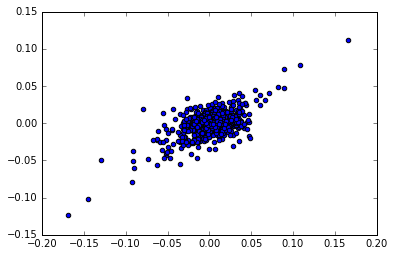

In [7]:
plt.scatter(out['USDT_ETH_PC'], out['USDT_BTC_PC'])

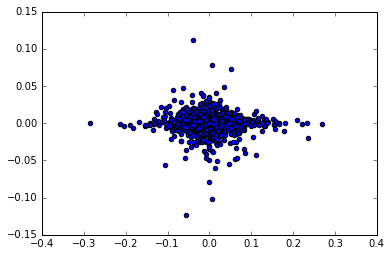

In [8]:
plt.scatter(out['BTC_BCN_PC'], out['USDT_BTC_PC'])

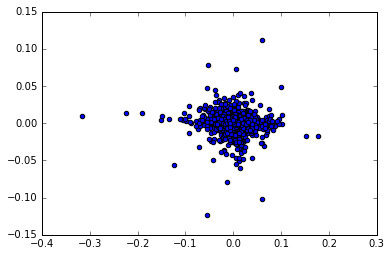

In [9]:
plt.scatter(out['BTC_XRP_PC'], out['USDT_BTC_PC'])

In [10]:
def consecutive_periods(df, columns):
    if not isinstance(columns, list):
        columns = list(columns)
    for col in columns:
        y = df[col].apply(lambda x: 1 if x>0 else 0)
        y = y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)
        df[col+'_cdw'] = y
    return df

In [11]:
out = consecutive_periods(out, [i for i in out.columns])

In [12]:
def get_trainingset(df, currency):
    
    X = df.copy()
    currency_col = [i for i in X.columns if currency in i]
    rest_col = list(set(X.columns) - set(currency_col))

    Y = X[currency_col]
    X = X[rest_col]
    return X, Y
    

In [13]:
label = 'XRP'
pair = 'BTC_{}_PC'.format(label)

In [14]:
X, Y = get_trainingset(out, label)
Y = Y[pair]

Y = pd.Series(Y.iloc[1:].values, index=Y.index[:-1])
mask0 = Y<-0.005
mask1 = Y>0.005

Y.loc[mask0] = 0
Y.loc[mask1] = 1

Y = Y[Y.isin([1, 0])]

X = X[X.index.isin(Y.index)]

print X.shape, Y.shape

(1915, 132) (1915,)


In [15]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from model_utils import *
from preprocessing import *

if len(Y.unique())>2:
    est = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, max_depth=4)
    est = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10, max_depth=4)
else:
    est = RandomForestClassifier(n_estimators=50, min_samples_leaf=10, max_depth=4)
    est = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=10, max_depth=4)   

res = do_easy_crossval(est, X, Y, folds=10, refit=True)

Trained fold 1
Trained fold 2
Trained fold 3
Trained fold 4
Trained fold 5
Trained fold 6
Trained fold 7
Trained fold 8
Trained fold 9
Trained fold 10


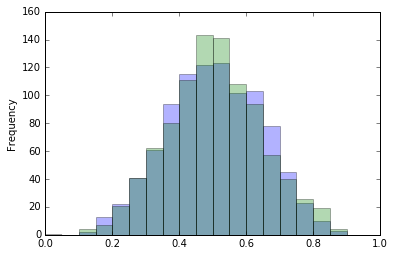

In [16]:
pred = res[0]
est = res[1]

fig, ax = plt.subplots(1,1)
# plt.scatter(pred['true'], pred['pred'])
# np.corrcoef(pred['true'], pred['pred'])[0][1]

mask = pred['true'] == 0
pred.loc[mask, 'proba'].plot(kind='hist', ax=ax, range=(0,1), bins=20, alpha=0.3)
mask = pred['true'] == 1
pred.loc[mask, 'proba'].plot(kind='hist', ax=ax, range=(0,1), bins=20, alpha=0.3)

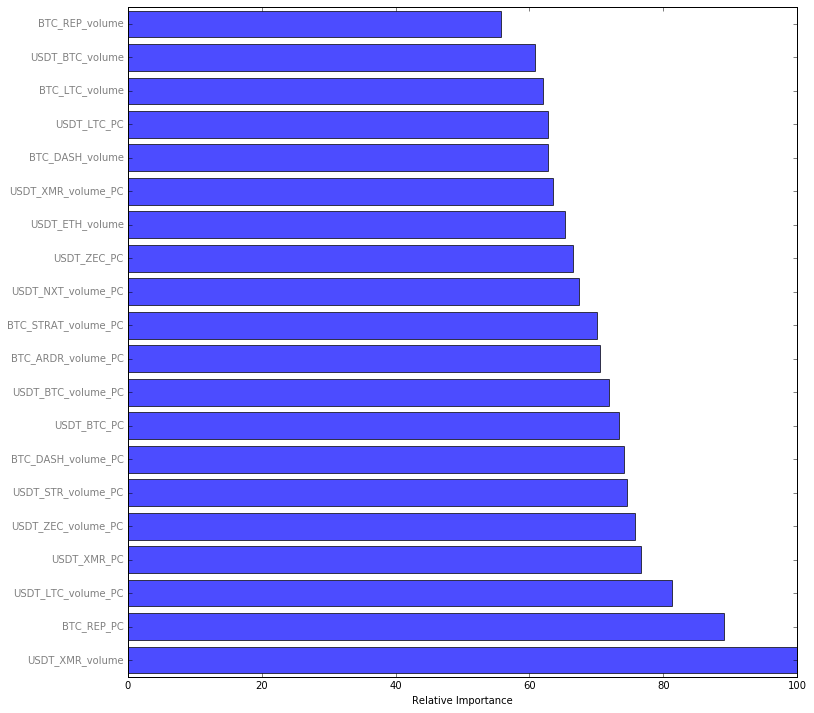

In [17]:
plot_feature_importances(est, X.columns, top=20)

In [18]:
pd.ewma?